# PyFit

In [2]:
import os
os.chdir('..')

In [3]:
from ROOT import TFile, TCanvas

Welcome to JupyROOT 6.14/04


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lmfit
from corner import corner

In [5]:
from multiprocessing import Pool

In [6]:
from femtofitter import PathQuery
from femtofitter.pyfitter import Data3D, FitterGauss

In [7]:
# filename = 'data-varyphi.root'
filename = 'Data-Cmp.root'

cent = '00_05'
kt = '0.4_0.5'
magfield = '++'
pair = 'pim'
cfg = 'cfg2962DF8ABB076C96'
mrc_cfg = 'cfgBDC0F09B1F286D46'

query = PathQuery('Q3DLCMS', cfg, pair, cent, kt, magfield)
mrc_query = PathQuery('AnalysisTrueQ3D', mrc_cfg, pair, '00_90', kt, magfield)

In [8]:
tfile = TFile.Open(filename)
assert tfile

tdir = tfile.Get(query.as_path())
assert tdir

mrc_tdir = tfile.Get(mrc_query.as_path())
assert mrc_tdir

mrc = mrc_tdir.Get("mrc")
assert mrc

In [9]:
data = Data3D.From(tdir, mrc, 0.14)

In [10]:
fitter = FitterGauss(data)

In [11]:
mini = fitter.pml_minimizer()

In [12]:
default_params = fitter.default_parameters()
result0 = mini.minimize(method='nelder', params=default_params)

In [13]:
result0.params.pretty_print()

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
Rl       5.702        0      inf     None     True     None     None
Ro       5.666        0      inf     None     True     None     None
Rs       5.248        0      inf     None     True     None     None
lam     0.4059        0      inf     None     True     None     None
norm    0.1694        0      inf     None     True     None     None


In [14]:
result1 = mini.minimize(method='leastsq', params=result0.params)
result1.params.pretty_print()

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
Rl       5.668        0      inf  0.01678     True     None     None
Ro       5.708        0      inf  0.01708     True     None     None
Rs       5.164        0      inf   0.0151     True     None     None
lam     0.3988        0      inf 0.001147     True     None     None
norm    0.1695        0      inf 1.141e-05     True     None     None


## $\chi^2$

In [15]:
c2mini = fitter.chi2_minimizer()

In [16]:
default_params = fitter.default_parameters()
cresult0 = c2mini.minimize(method='nelder', params=default_params)

In [17]:
cresult0.params.pretty_print()

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
Rl       5.681        0      inf     None     True     None     None
Ro       5.664        0      inf     None     True     None     None
Rs       5.231        0      inf     None     True     None     None
lam      0.404        0      inf     None     True     None     None
norm    0.1692        0      inf     None     True     None     None


In [17]:
cresult0.params.pretty_print()

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
Rl        5.72        0      inf     None     True     None     None
Ro        5.63        0      inf     None     True     None     None
Rs       5.278        0      inf     None     True     None     None
lam     0.4084        0      inf     None     True     None     None
norm    0.1691        0      inf     None     True     None     None


In [12]:
cresult1 = c2mini.minimize(method='leastsq', params=cresult0.params)
cresult1.params.pretty_print()

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
Rl       5.681        0      inf  0.02216     True     None     None
Ro       5.664        0      inf  0.02335     True     None     None
Rs       5.231        0      inf  0.02008     True     None     None
lam      0.404        0      inf  0.00198     True     None     None
norm    0.1692        0      inf 1.302e-05     True     None     None


In [18]:
tmparams = cresult0.params.copy()

In [19]:
tmparams = cresult0.params.copy()
for key in ("Ro", "Rs", "Rl"):
    tmparams[key].vary = False

In [20]:
tmparams['Ro']

<Parameter 'Ro', value=5.66361145061043 (fixed), bounds=[0.0:inf]>

In [21]:
ratio = (data.num / data.den)[data.num > 0]
short_data = (ratio, ratio * ((1.0 + ratio) / data.den[data.num > 0]))
qspace = data.qspace[:, data.num > 0]
qinv = data.qinv[data.num > 0]

In [22]:
def objective_function(model):
    return ((short_data[0] - model) ** 2 / short_data[1]).sum()

In [23]:
def calc_fsi(R):
    from femtofitter.pyfitter import COULOMB_INTERP
    return COULOMB_INTERP(qinv, R)

In [24]:
def userfcn(params, *args):
    model = FitterGauss.func(params, qspace, calc_fsi)
    return objective_function(model)

In [25]:
emini = lmfit.Minimizer(userfcn, tmparams)

In [26]:
tmparams = cresult0.params.copy()
for key in ("norm", ):
    tmparams[key].vary = False

In [31]:
%%time
with Pool() as pool:
    tmpres = emini.emcee(params=tmparams,
                         workers=pool,
                         burn=300,
                         is_weighted=True,
                         float_behavior='chi2')
tmpres.params.pretty_print()

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
Rl        5.66        0      inf   0.0144     True     None     None
Ro       5.636        0      inf  0.01448     True     None     None
Rs       5.216        0      inf  0.01232     True     None     None
lam     0.4006        0      inf 0.001227     True     None     None
norm    0.1692        0      inf     None    False     None     None
CPU times: user 1min 7s, sys: 6.06 s, total: 1min 13s
Wall time: 9min 40s


In [50]:
?corner

Signature:
corner(
    ['xs', 'bins=20', 'range=None', 'weights=None', "color='k'", 'smooth=None', 'smooth1d=None', 'labels=None', 'label_kwargs=None', 'show_titles=False', "title_fmt='.2f'", 'title_kwargs=None', 'truths=None', "truth_color='#4682b4'", 'scale_hist=False', 'quantiles=None', 'verbose=False', 'fig=None', 'max_n_ticks=5', 'top_ticks=False', 'use_math_text=False', 'hist_kwargs=None', '**hist2d_kwargs'],
)
Docstring:
Make a *sick* corner plot showing the projections of a data set in a
multi-dimensional space. kwargs are passed to hist2d() or used for
`matplotlib` styling.

Parameters
----------
xs : array_like[nsamples, ndim]
    The samples. This should be a 1- or 2-dimensional array. For a 1-D
    array this results in a simple histogram. For a 2-D array, the zeroth
    axis is the list of samples and the next axis are the dimensions of
    the space.

bins : int or array_like[ndim,]
    The number of bins to use in histograms, either as a fixed value for
    all dimension

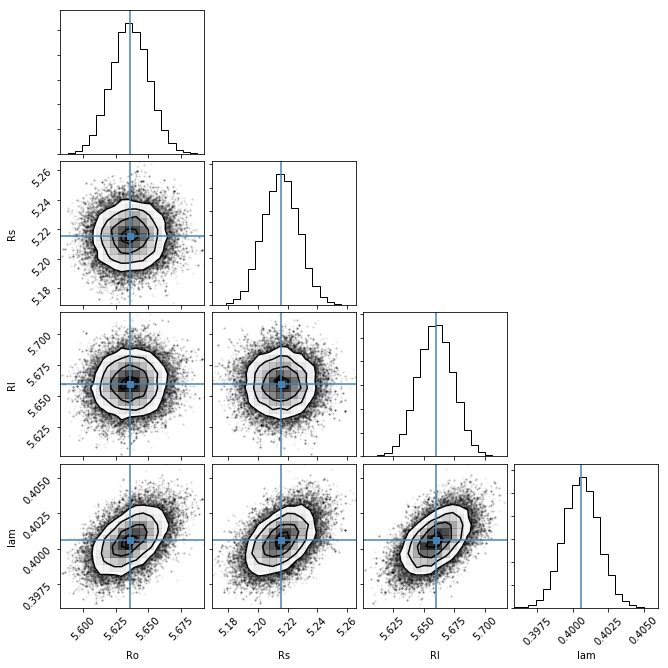

In [51]:
cres = corner(tmpres.flatchain,
               labels=tmpres.var_names,
                #        quantiles=(0.16, 0.84),
               truths=list(tmpres.params.valuesdict().values()))

plt.show()

In [62]:
for i, ax in enumerate(cres.axes):
    if i % 4 in (0, 2):
        ax.set_xlim(5.15, 5.8)
#         print(ax.get_xlabel())

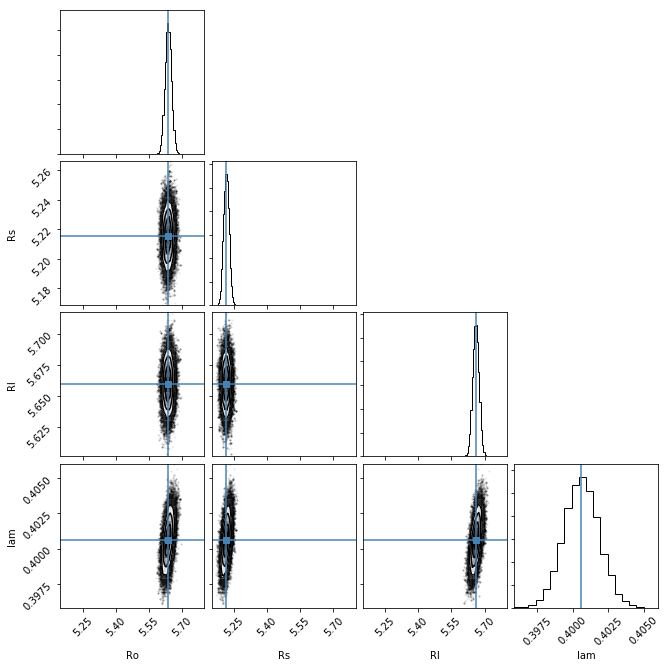

In [63]:
cres

In [48]:
np.array(tmpres.flatchain.lam).std()

0.0012377375859599343

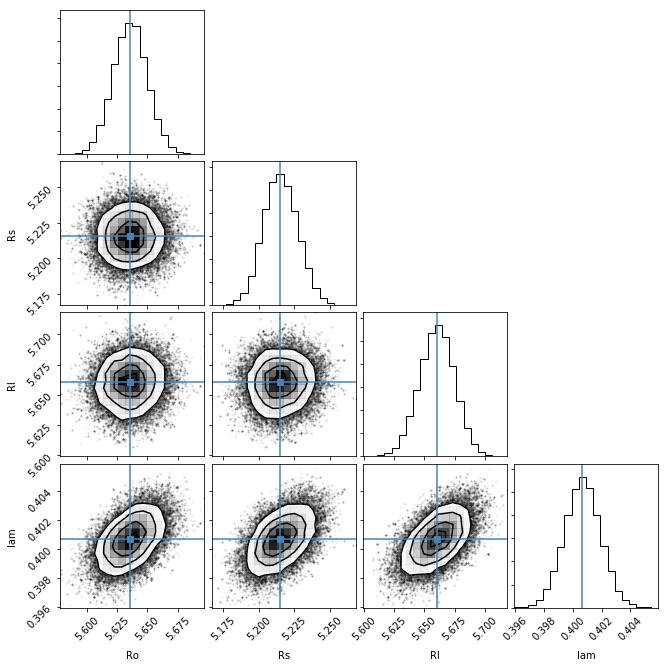

In [95]:
from corner import corner
corner(tmpres.flatchain, labels=tmpres.var_names, truths=list(tmpres.params.valuesdict().values()))
plt.show()

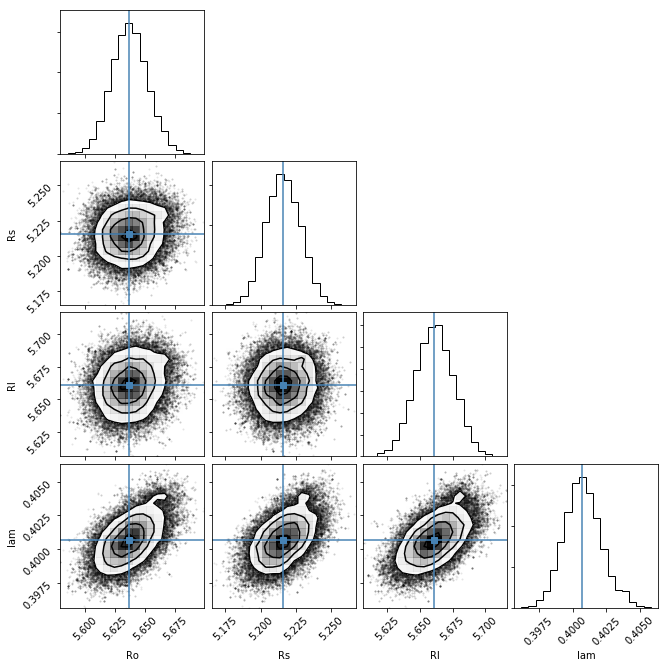

In [93]:
from corner import corner
corner(tmpres.flatchain, labels=tmpres.var_names, truths=list(tmpres.params.valuesdict().values()))
plt.show()

In [79]:
%%time
with Pool() as pool:
    tmpres = emini.emcee(workers=pool,
                         is_weighted=True,
                         float_behavior='chi2')
tmpres.params.pretty_print()

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
Rl       5.681        0      inf     None    False     None     None
Ro       5.664        0      inf     None    False     None     None
Rs       5.231        0      inf     None    False     None     None
lam     0.4022        0      inf 0.0007898     True     None     None
norm    0.1693        0      inf 8.08e-06     True     None     None
CPU times: user 1min 3s, sys: 7.13 s, total: 1min 10s
Wall time: 6min 59s


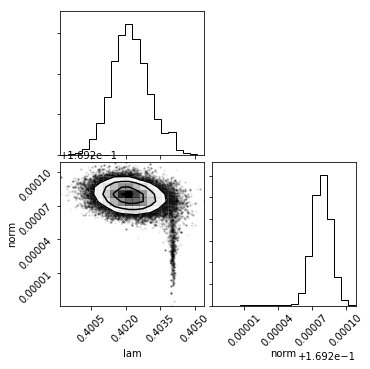

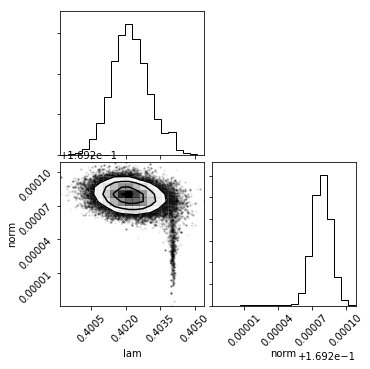

In [81]:
from corner import corner
corner(tmpres.flatchain, labels=tmpres.var_names, truths=list(tmpres.params.valuesdict().values()))
plt.show()

In [18]:
cresult1 = c2mini.minimize(method='leastsq', params=cresult0.params)
cresult1.params.pretty_print()

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
Rl        5.72        0      inf  0.02042     True     None     None
Ro        5.63        0      inf  0.02204     True     None     None
Rs       5.278        0      inf  0.01837     True     None     None
lam     0.4084        0      inf 0.001973     True     None     None
norm    0.1691        0      inf 1.295e-05     True     None     None


In [13]:
cci, trace = lmfit.conf_interval(c2mini, cresult1, trace=True)
lmfit.printfuncs.report_ci(cci)

         99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 Ro  :  -0.06828  -0.04539  -0.02249   5.66371  +0.02316  +0.04641  +0.06975
 Rs  :  -0.05856  -0.03908  -0.01960   5.23115  +0.01968  +0.03940  +0.05915
 Rl  :  -0.06827  -0.04561  -0.02275   5.68051  +0.02292  +0.04607  +0.06914
 lam :  -0.00602  -0.00401  -0.00200   0.40405  +0.00203  +0.00407  +0.00610
 norm:  -0.00004  -0.00003  -0.00001   0.16922  +0.00001  +0.00003  +0.00004


In [19]:
cci, trace = lmfit.conf_interval(c2mini, cresult1, trace=True)
lmfit.printfuncs.report_ci(cci)

         99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 Ro  :  -0.06513  -0.04353  -0.02182   5.62990  +0.02189  +0.04358  +0.06554
 Rs  :  -0.05405  -0.03605  -0.01806   5.27773  +0.01812  +0.03627  +0.05448
 Rl  :  -0.06359  -0.04252  -0.02123   5.71987  +0.02130  +0.04280  +0.06435
 lam :  -0.00606  -0.00405  -0.00203   0.40840  +0.00204  +0.00407  +0.00610
 norm:  -0.00004  -0.00003  -0.00001   0.16907  +0.00001  +0.00003  +0.00004


In [20]:
ci, trace = lmfit.conf_interval(mini, result1, trace=True)
lmfit.printfuncs.report_ci(ci)

/home/akubera/.local/lib/python3.6/site-packages/lmfit/confidence.py:303: UserWarning: Warning, rel_change=0.0 < 0.01  at iteration 1 and prob(Rl=5.684555454325357) = 0.0 < max(sigmas).
  warn(errmsg)


         99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 Ro  :  -0.03767  -0.02463  -0.01224   5.70755  +0.02135  +0.03364  +0.04696
 Rs  :  -0.02989  -0.01855  -0.00844   5.16361  +0.02050  +0.03163  +0.04317
 Rl  :  -0.03514  -0.02218  -0.01037   5.66777      +inf      +inf      +inf
 lam :  -0.00255  -0.00163  -0.00071   0.39880  +0.00130  +0.00218  +0.00313
 norm:  -0.00001  -0.00001  -0.00001   0.16946      +inf      +inf      +inf


/home/akubera/.local/lib/python3.6/site-packages/lmfit/confidence.py:303: UserWarning: Warning, rel_change=0.0 < 0.01  at iteration 1 and prob(norm=0.1694700042934604) = 0.0 < max(sigmas).
  warn(errmsg)


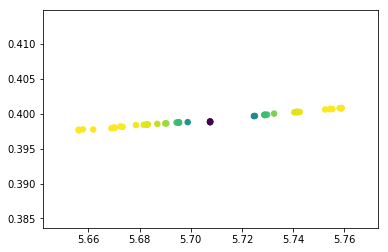

In [26]:
x, y, prob = trace['Ro']['Ro'], trace['Ro']['lam'], trace['Ro']['prob']
plt.scatter(x, y, c=prob, s=30)

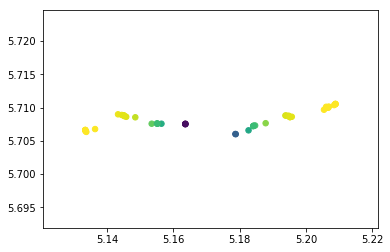

In [28]:
k1, k2 = 'Rs', 'Ro'
x, y, prob = trace[k1][k1], trace[k1][k2], trace[k1]['prob']
plt.scatter(x, y, c=prob, s=30)

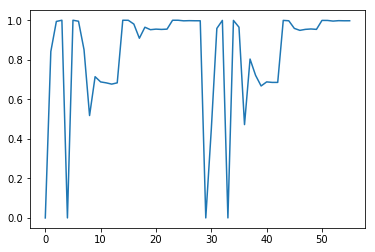

In [25]:
plt.plot(trace['Ro']['prob'])

In [14]:
qinv_tdir = tfile.Get(qinv_path)

In [15]:
mass = 0.13957

In [16]:
kt_dist = qinv_tdir.Get("kt_dist")
if kt_dist:
    avg_kt = kt_dist.GetMean()
    del kt_dist
else:
    avg_kt = PathQuery.from_path(path).mean_kt()
gamma = np.sqrt(avg_kt*avg_kt + mass*mass) / mass

In [17]:

# fittergauss4 = FitterGauss4.FromDirectory(tdir, 0.15)

In [18]:
# Data3D.From(tdir, 0.19)

In [17]:
limit = 0.19
data = Data3D.From(tdir, limit)
fitter = FitterGauss6(data)
mini = fitter.pml_minimizer() 

In [20]:
mr = mini.minimize(method='nelder')
mr.params.pretty_print()

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
Rl       4.934        0      inf     None     True     None     None
Rlo    -0.0267     -inf      inf     None     True     None     None
Ro       4.702        0      inf     None     True     None     None
Ros   -0.02847     -inf      inf     None     True     None     None
Rs       4.612        0      inf     None     True     None     None
Rsl    0.05369     -inf      inf     None     True     None     None
lam     0.4388        0      inf     None     True     None     None
norm    0.2541        0      inf     None     True     None     None


In [20]:
mr = mini.minimize(method='nelder')
mr.params.pretty_print()

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
Rl       4.919        0      inf     None     True     None     None
Rlo   -0.008093     -inf      inf     None     True     None     None
Ro       4.673        0      inf     None     True     None     None
Ros   -0.01741     -inf      inf     None     True     None     None
Rs       4.615        0      inf     None     True     None     None
Rsl      0.023     -inf      inf     None     True     None     None
lam     0.4384        0      inf     None     True     None     None
norm    0.2543        0      inf     None     True     None     None


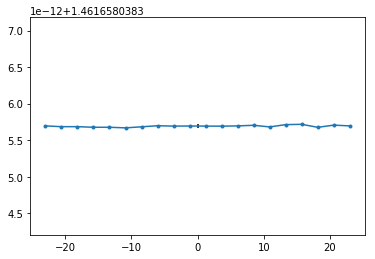

In [22]:
key = 'Rsl'
X = np.linspace(-1000, 1000, 20) * mr.params[key].value
vrsid = fitter.vary_chi2(mr, key, values=X, data=data)

vrsidre = (vrsid ** 2).sum(axis=1) / mr.nfree
plt.plot(X, vrsidre, marker='.')
plt.vlines(mr.params[key].value, vrsidre.min(), vrsidre.max())
plt.show()

In [23]:
vrsidre

array([1.46165804, 1.46165804, 1.46165804, 1.46165804, 1.46165804,
       1.46165804, 1.46165804, 1.46165804, 1.46165804, 1.46165804,
       1.46165804, 1.46165804, 1.46165804, 1.46165804, 1.46165804,
       1.46165804, 1.46165804, 1.46165804, 1.46165804, 1.46165804])

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
Rl       4.905        0      inf     None     True     None     None
Rlo   0.003059     -inf      inf     None     True     None     None
Ro       4.659        0      inf     None     True     None     None
Ros   -0.01028     -inf      inf     None     True     None     None
Rs       4.603        0      inf     None     True     None     None
Rsl   0.002836     -inf      inf     None     True     None     None
lam     0.4379        0      inf     None     True     None     None
norm    0.2542        0      inf     None     True     None     None


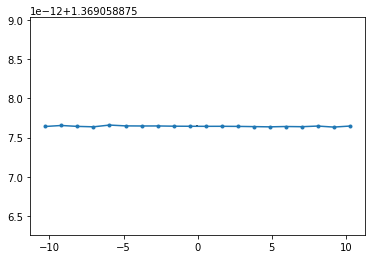

In [24]:
limit = 0.21
data = Data3D.From(tdir, limit)
fitter = FitterGauss6(data)
mini = fitter.pml_minimizer()

mr = mini.minimize(method='nelder')
mr.params.pretty_print()

key = 'Ros'
X = np.linspace(-1000, 1000, 20) * mr.params[key].value
vrsid = fitter.vary_chi2(mr, key, values=X, data=data)

vrsidre = (vrsid ** 2).sum(axis=1) / mr.nfree
plt.plot(X, vrsidre, marker='.')
plt.vlines(mr.params[key].value, vrsidre.min(), vrsidre.max())
plt.show()

In [25]:
cowboy_mask = (data.qspace[0] > 0) & (data.qspace[1] > 0) & (data.qspace[2] > 0)

In [26]:
data.num[cowboy_mask].shape

(9261,)

In [27]:
data.den[cowboy_mask]

array([221214., 219276., 215705., ..., 123552., 122968., 120866.],
      dtype=float32)

In [28]:
data.qspace.shape

(3, 79507)

In [29]:
(data.qspace[0][cowboy_mask] * data.qspace[2][cowboy_mask]).sum()

112.05810000000002

In [30]:
wqos.sum()

NameError: name 'wqos' is not defined

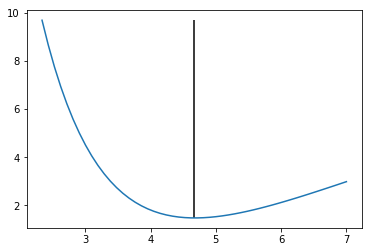

In [31]:
mr.residual.sum(), mr.chisqr, (fitter.chi2_of(mr) ** 2).sum()

(108768.95298374318, 1091291.464781831, 110748.91238294664)

In [32]:
mr.residual.sum(), mr.chisqr, (fitter.chi2_of(mr) ** 2).sum()

(108768.95298374318, 1091291.464781831, 110748.91238294664)

In [33]:
c2mini = fitter.chi2_minimizer() 
mrc = c2mini.minimize(method='nelder')
mrc.params.pretty_print()


Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
Rl       4.903        0      inf     None     True     None     None
Rlo   -0.02526     -inf      inf     None     True     None     None
Ro       4.663        0      inf     None     True     None     None
Ros   -0.02705     -inf      inf     None     True     None     None
Rs       4.599        0      inf     None     True     None     None
Rsl     0.0138     -inf      inf     None     True     None     None
lam      0.437        0      inf     None     True     None     None
norm    0.2542        0      inf     None     True     None     None


In [14]:
c2mini = fitter.chi2_minimizer() 
mrc = c2mini.minimize(method='nelder')
mrc.params.pretty_print()


Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
Rl        4.95        0      inf     None     True     None     None
Rlo   -0.01718     -inf      inf     None     True     None     None
Ro       4.708        0      inf     None     True     None     None
Ros   -0.008108     -inf      inf     None     True     None     None
Rs       4.639        0      inf     None     True     None     None
Rsl   0.008811     -inf      inf     None     True     None     None
lam     0.4382        0      inf     None     True     None     None
norm    0.2546        0      inf     None     True     None     None


In [21]:
(fitter.chi2_of(mrc) ** 2).sum()

54707.7723222522

In [22]:
mrc.redchi

1.7997285140756614

In [23]:
mrc.residual

array([16.17260671, 14.29968896, 13.23195595, ..., -0.9979966 ,
       -1.23747044,  0.2272599 ])

In [24]:
(mrc.residual**2).sum(), mrc.chisqr, (fitter.chi2_of(mrc) ** 2).sum()

(53601.314334715426, 53601.314334715426, 54707.7723222522)

In [35]:
(mr.residual**2).sum(), mr.chisqr, (fitter.chi2_of(mr) ** 2).sum()

(1091291.464781831, 1091291.464781831, 110748.91238294664)

In [34]:
mrc.residual[9]

3.0616878607067206

In [36]:
resid = fitter.chi2_of(mrc)

In [31]:
params = mr.params
params.R
mr2 = mini.minimize(method='leastsq', params=mr.params)
mr2.params.pretty_print()

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
Rl       4.963        0      inf 0.007753     True     None     None
Rlo     -136.1     -inf      inf     2381     True     None     None
Ro       4.862        0      inf 0.006959     True     None     None
Ros      607.6     -inf      inf     6119     True     None     None
Rs       4.556        0      inf  0.00856     True     None     None
Rsl     -14.95     -inf      inf    330.6     True     None     None
lam     0.4343        0      inf 0.002352     True     None     None
norm    0.2549        0      inf 1.777e-05     True     None     None


In [32]:
(mr2.residual**2).sum(), mr2.chisqr, (fitter.chi2_of(mr2) ** 2).sum()

(904525.218385218, 904525.218385218, 56768.61318295233)

In [28]:
resid[9]

4.866100716826363

In [29]:
mrc.params

Parameters([('Ro', <Parameter 'Ro', 4.707942791418974, bounds=[0.0:inf]>),
            ('Rs', <Parameter 'Rs', 4.639150848310818, bounds=[0.0:inf]>),
            ('Rl', <Parameter 'Rl', 4.949687481570087, bounds=[0.0:inf]>),
            ('Ros',
             <Parameter 'Ros', -0.008107618754435969, bounds=[-inf:inf]>),
            ('Rsl',
             <Parameter 'Rsl', 0.008811286898363586, bounds=[-inf:inf]>),
            ('Rlo',
             <Parameter 'Rlo', -0.017178040341238588, bounds=[-inf:inf]>),
            ('lam', <Parameter 'lam', 0.4382353486774775, bounds=[0.0:inf]>),
            ('norm',
             <Parameter 'norm', 0.2545709995535348, bounds=[0.0:inf]>)])

In [37]:
mrc = c2mini.minimize(method='leastsq', params=mrc.params)
mrc.params.pretty_print()

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
Rl       4.903        0      inf 0.008264     True     None     None
Rlo    -0.6344     -inf      inf    492.1     True     None     None
Ro       4.663        0      inf 0.007936     True     None     None
Ros    -0.4608     -inf      inf    469.5     True     None     None
Rs       4.599        0      inf 0.007554     True     None     None
Rsl      1.126     -inf      inf    236.7     True     None     None
lam      0.437        0      inf 0.002258     True     None     None
norm    0.2542        0      inf 5.719e-06     True     None     None


In [23]:
mr = mini.minimize(method='leastsq', params=mr.params)
mr.params.pretty_print()

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
Rl       4.963        0      inf 0.007753     True     None     None
Ro       4.862        0      inf 0.006959     True     None     None
Rol     -136.1     -inf      inf     2381     True     None     None
Ros      607.6     -inf      inf     6119     True     None     None
Rs       4.556        0      inf  0.00856     True     None     None
Rsl     -14.95     -inf      inf    330.6     True     None     None
lam     0.4343        0      inf 0.002352     True     None     None
norm    0.2549        0      inf 1.777e-05     True     None     None


In [30]:
mrc.params['Ros']

<Parameter 'Ros', 22.468841444267095, bounds=[-inf:inf]>

In [34]:
mini._fjk

<bound method Minimizer.scalar_minimize of <lmfit.minimizer.Minimizer object at 0x7f1a9fcfb128>>

In [39]:
mrc.chisqr

108829.50858799001

In [40]:
mrc.chisqr, mr.chisqr

(108829.50858799001, 1091291.464781831)

In [41]:
mini.userfcn()

TypeError: _eval() missing 1 required positional argument: 'params'

In [42]:
c2mini.reduce_fcn

<function lmfit.minimizer.reduce_chisquare(r)>

In [22]:
mr.chisqr

952535.9632559313

In [18]:
mr.params.pretty_print()

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
Rl       4.963        0      inf     None     True     None     None
Ro       4.862        0      inf     None     True     None     None
Rol   -0.000593     -inf      inf     None     True     None     None
Ros   -0.007818     -inf      inf     None     True     None     None
Rs       4.556        0      inf     None     True     None     None
Rsl   -0.007305     -inf      inf     None     True     None     None
lam     0.4343        0      inf     None     True     None     None
norm    0.2549        0      inf     None     True     None     None


In [43]:
mr.params['Ro'].value *= 1.2

In [44]:
mr.params

Parameters([('Ro', <Parameter 'Ro', 5.59063574842359, bounds=[0.0:inf]>),
            ('Rs', <Parameter 'Rs', 4.603186851129628, bounds=[0.0:inf]>),
            ('Rl', <Parameter 'Rl', 4.90489832434173, bounds=[0.0:inf]>),
            ('lam', <Parameter 'lam', 0.4378638411309086, bounds=[0.0:inf]>),
            ('norm',
             <Parameter 'norm', 0.25418781320472483, bounds=[0.0:inf]>),
            ('Ros',
             <Parameter 'Ros', -0.010275183503530867, bounds=[-inf:inf]>),
            ('Rsl',
             <Parameter 'Rsl', 0.0028360438049029983, bounds=[-inf:inf]>),
            ('Rlo',
             <Parameter 'Rlo', 0.0030589310640089665, bounds=[-inf:inf]>)])

In [45]:
# from lmfit.minimizer import MinimizerResult
# lmfit.minimizer.
from lmfit import MinimizerResult

ImportError: cannot import name 'MinimizerResult'

In [46]:
mr.params.pretty_print()

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
Rl       4.905        0      inf     None     True     None     None
Rlo   0.003059     -inf      inf     None     True     None     None
Ro       5.591        0      inf     None     True     None     None
Ros   -0.01028     -inf      inf     None     True     None     None
Rs       4.603        0      inf     None     True     None     None
Rsl   0.002836     -inf      inf     None     True     None     None
lam     0.4379        0      inf     None     True     None     None
norm    0.2542        0      inf     None     True     None     None


In [18]:
mr.params.pretty_print()

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
Rl       4.964        0      inf     None     True     None     None
Ro       4.862        0      inf     None     True     None     None
Rol   -0.002818     -inf      inf     None     True     None     None
Ros   -0.0005931     -inf      inf     None     True     None     None
Rs       4.556        0      inf     None     True     None     None
Rsl   -0.007818     -inf      inf     None     True     None     None
lam     0.4343        0      inf     None     True     None     None
norm    0.2549        0      inf     None     True     None     None


In [23]:
chi2_calc = fitter.chi2_calculator(data.num, data.den)

NameError: name 'data' is not defined

In [23]:
chi2_calc(mr.params) / mr.nfree

1.884046679032067

In [24]:
p = mr.params.copy()
# chi2_calc(mr.params) / mr.nfree

In [25]:
p['Ro'] *= 1.2
chi2_calc(p) / mr.nfree

ValueError: '5.8348806970671605' is not a Parameter

In [16]:
# X = np.linspace(0.10, 0.21, 11)
# minilist = [fitter.fit_pml(Data3D.From(tdir, limit), gamma) for limit in X]

In [18]:
# results1 = [mini.minimize(method='nelder') for mini in minilist]

KeyboardInterrupt: 

In [ ]:
results2 = [mini.minimize(method='leastsq', params=res.params) for mini, res in zip(minilist, results1)]

In [ ]:
results2[0].params['Ro'].value

In [ ]:
results2[0].params['Ro'].value

In [ ]:
Ro = np.array([r.params['Ro'].value for r in results2])
Roerr = np.array([r.params['Ro'].stderr for r in results2])

In [86]:
Ro

array([4.95133566, 4.92516785, 4.89831865, 4.88099075, 4.86502881,
       4.841801  , 4.83581232, 4.8292107 , 4.8218385 , 4.81494777,
       4.80798785])

In [47]:
# plt.errorbar(x=X, y=Ro, yerr=Roerr)
plt.errorbar(x=X, y=Ro, yerr=Roerr)

# plt.ylim(0.97, 1.03);

NameError: name 'Ro' is not defined

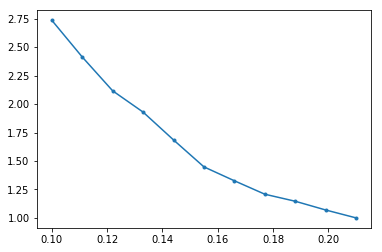

In [88]:
plt.plot(X, Roerr / Roerr[-1], marker='.')
# plt.ylim(0.97, 1.03);

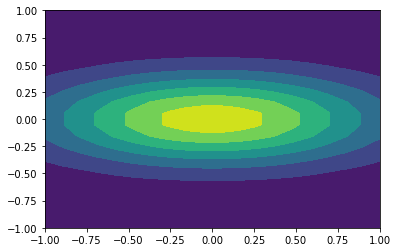

In [141]:
x = np.linspace(-1, 1, 20)
# x = np.random.normal(0, .15, 40)
# x = x[(-1 <= x) & (x <= 1)]
# y = sorted(np.random.uniform(-1, 1, 40))
y = x
xx, yy = np.meshgrid(x,y)
zz = np.exp(- xx ** 2 - 6 * yy ** 2)
plt.contourf(xx, yy, zz)
# plt.scatter(xx, yy)

(array([1., 4., 9., 7., 7., 4., 4., 2., 1., 1.]),
 array([-0.29527882, -0.22370928, -0.15213973, -0.08057018, -0.00900063,
         0.06256891,  0.13413846,  0.20570801,  0.27727755,  0.3488471 ,
         0.42041665]),
 <a list of 10 Patch objects>)

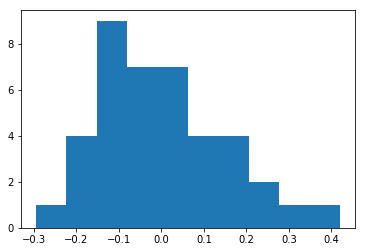

In [139]:
plt.hist(x)

In [97]:
(fitter.chi2_minimizer(data)(mr.params) ** 2).sum()

TypeError: func() missing 2 required positional arguments: 'qspace' and 'fsi'

In [24]:
mr = mini.minimize(method='leastsq', params=mr.params)
mr.params.pretty_print()

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
Rl       4.964        0      inf  0.00999     True     None     None
Ro       4.723        0      inf 0.009596     True     None     None
Rol   -0.08087     -inf      inf  0.06301     True     None     None
Ros     -0.341     -inf      inf  0.05968     True     None     None
Rs       4.651        0      inf 0.009126     True     None     None
Rsl   -0.01607     -inf      inf  0.06183     True     None     None
lam     0.4404        0      inf 0.001118     True     None     None
norm    0.2546        0      inf  1.2e-05     True     None     None


In [18]:
mr = mini.minimize(method='leastsq', params=mr.params)
mr.params.pretty_print()

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
Rl       4.958        0      inf  0.01027     True     None     None
Ro       4.708        0      inf 0.009845     True     None     None
Rol   -0.03658     -inf      inf  0.06456     True     None     None
Ros     0.2594     -inf      inf  0.06123     True     None     None
Rs       4.651        0      inf  0.00939     True     None     None
Rsl    0.02625     -inf      inf  0.06356     True     None     None
lam     0.4325        0      inf 0.001125     True     None     None
norm    0.2546        0      inf 1.215e-05     True     None     None


In [19]:
mr = mini.minimize(method='leastsq', params=mr.params)
mr.params.pretty_print()

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
Rl       4.958        0      inf  0.01027     True     None     None
Ro       4.708        0      inf 0.009845     True     None     None
Rol   -0.03665     -inf      inf  0.06456     True     None     None
Ros     0.2594     -inf      inf  0.06123     True     None     None
Rs       4.651        0      inf  0.00939     True     None     None
Rsl    0.02628     -inf      inf  0.06356     True     None     None
lam     0.4325        0      inf 0.001125     True     None     None
norm    0.2546        0      inf 1.215e-05     True     None     None


In [27]:
results2[0].params.pretty_print()

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
Rl       4.975        0      inf 0.008356     True     None     None
Ro       4.865        0      inf 0.007522     True     None     None
Rol   -0.08231     -inf      inf  0.05955     True     None     None
Ros    -0.7046     -inf      inf  0.06977     True     None     None
Rs       4.569        0      inf 0.009231     True     None     None
Rsl   0.004729     -inf      inf  0.04776     True     None     None
lam     0.4347        0      inf 0.000663     True     None     None
norm     0.255        0      inf 2.004e-05     True     None     None


In [20]:
mr = mini.minimize(method='leastsq', params=mr.params)
mr.params.pretty_print()

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
Rl       4.958        0      inf  0.01027     True     None     None
Ro       4.708        0      inf 0.009845     True     None     None
Rol   -0.03666     -inf      inf  0.06456     True     None     None
Ros     0.2594     -inf      inf  0.06123     True     None     None
Rs       4.651        0      inf  0.00939     True     None     None
Rsl    0.02626     -inf      inf  0.06356     True     None     None
lam     0.4325        0      inf 0.001125     True     None     None
norm    0.2546        0      inf 1.215e-05     True     None     None


mr.params.pretty_print()

In [89]:
mr = mini.minimize(method='leastsq', params=mr.params)
mr.params.pretty_print()

NameError: name 'mini' is not defined

In [55]:
# ci = lmfit.conf_interval(mini, mr)
# lmfit.printfuncs.report_ci(ci)

In [29]:
ci, trace = lmfit.conf_interval(mini, mr, sigmas=[1, 2],
                                trace=True, verbose=False)
lmfit.printfuncs.report_ci(ci)

NameError: name 'mini' is not defined

In [28]:
x, y, prob = trace['Ros']['Ros'], trace['Ros']['lam'], trace['Ros']['prob']
x2, y2, prob2 = trace['lam']['lam'], trace['lam']['Ro'], trace['lam']['prob']
# plt.scatter(x, y, c=prob ,s=30)
plt.scatter(x2, y2, c=prob2, s=30)
# plt.gca().set_xlim((2.5, 3.5))
# plt.gca().set_ylim((11.5, 12.5))
plt.xlabel('Ro')
plt.ylabel('lam')
plt.show()

NameError: name 'trace' is not defined

In [60]:
x2

array([0.43745186, 0.43630705, 0.43745186, 0.43630705, 0.43745186,
       0.43630705, 0.43745186, 0.43630705, 0.43632546, 0.43634345,
       0.43745186, 0.43859667, 0.43974149, 0.4408863 , 0.43745186,
       0.4408863 , 0.43745186, 0.4408863 , 0.43745186, 0.4408863 ,
       0.44029449, 0.43895834, 0.44005844, 0.43970689, 0.43983078,
       0.43981026, 0.43979927])

In [30]:
ci['Ro']

[(0.9544997361036416, 4.688523392767685),
 (0.6826894921370859, 4.698329760470407),
 (0.0, 4.708095369322306),
 (0.6826894921370859, 4.71788034802757),
 (0.9544997361036416, 4.727784556032493)]

In [33]:
trace['Rs']['Ro']

array([4.70809537, 4.70741644, 4.70673423, 4.70809536, 4.70673423,
       4.7071238 , 4.70760624, 4.70737443, 4.70741211, 4.70742053,
       4.70742053, 4.70673423, 4.70674268, 4.70809537, 4.70877103,
       4.70944336, 4.71011248, 4.70809536, 4.71011248, 4.70947931,
       4.7087891 , 4.70876211, 4.70877148, 4.70877148, 4.71011248,
       4.709931  , 4.70935244, 4.70952905, 4.70945677, 4.70944506])

In [34]:
trace['Ro']['Rs']

array([4.65095964, 4.65030118, 4.64963968, 4.65095965, 4.64963968,
       4.65001798, 4.65048985, 4.65026137, 4.6502986 , 4.65030648,
       4.65030648, 4.64963968, 4.64964758, 4.65095964, 4.6516151 ,
       4.65226754, 4.65095965, 4.65226754, 4.65189609, 4.6514318 ,
       4.65165538, 4.65161899, 4.65161116, 4.65161116, 4.65226754,
       4.65225973])

In [25]:
import corner

In [26]:
# import corner
# import numpy as np

# ndim, nsamples = 2, 10000
# np.random.seed(42)
# samples = np.random.randn((nsamples, ndim))
# figure = corner.corner(samples, quantiles=[0.16, 0.5, 0.84])


In [27]:
samples.shape

NameError: name 'samples' is not defined

In [ ]:
cx, cy, grid = lmfit.conf_interval2d(mini, mr, 'Ro', 'lam', 30, 30)
figure = corner.corner(samples, quantiles=[0.16, 0.5, 0.84])


In [76]:
Ro
rX = np.random.uniform(4.5, 5.5, size=(30, 30))

In [ ]:
import emcee

In [ ]:
nwalkers = 1000
ndim = 3
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprobd, args=(x, y, yerr))

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
cx, cy, grid = lmfit.conf_interval2d(mini, mr, 'Ro', 'lam', 30, 30)
plt.contourf(cx, cy, grid, np.linspace(0, 1, 11))
plt.colorbar()
plt.xlabel('Ro')
plt.ylabel('lam')

In [ ]:
cx

In [ ]:
cy

In [ ]:
cx, cy, grid = lmfit.conf_interval2d(mini, mr, 'Ro', 'Rs', 30, 30)
plt.contourf(cx, cy, grid, np.linspace(0, 1, 11))
plt.colorbar()
plt.xlabel('Ro')
plt.ylabel('Rs')

In [ ]:
plt.close()
cx, cy, grid = lmfit.conf_interval2d(mini, mr, 'Rs', 'lam', 30, 30)
plt.contourf(cx, cy, grid, np.linspace(0, 1, 11))
plt.colorbar()
plt.xlabel('Rs')
plt.ylabel('lam')

In [ ]:
key1 = 'Rl'
plt.close()
cx, cy, grid = lmfit.conf_interval2d(mini, mr, key1, 'lam', 30, 30)
plt.contourf(cx, cy, grid, np.linspace(0, 1, 11))
plt.colorbar()
plt.xlabel(key1)
plt.ylabel('lam')

In [ ]:
?lmfit.conf_interval2d

In [ ]:
trace['Ro']['Rs']

In [ ]:
errors = mini.emcee(params=mr.params, workers=10)

In [ ]:
errors.params

In [ ]:
import corner

In [ ]:
xaxis, yaxis, zaxis =  (get_ax(num) for get_ax in iter_axes)

zstart, zstop = zaxis.FindBin(-fit_range), zaxis.FindBin(fit_range) + 1
ystart, ystop = yaxis.FindBin(-fit_range), yaxis.FindBin(fit_range) + 1
xstart, xstop = xaxis.FindBin(-fit_range), xaxis.FindBin(fit_range) + 1

slices = (slice(zstart,zstop), slice(ystart,ystop), slice(xstart,xstop))
slices

In [ ]:
from itertools import starmap

In [ ]:
tuple(starmap(slice, [(ax.FindBin(-fit_range), ax.FindBin(fit_range) +1) for ax in (get_ax(num) for get_ax in iter_axes)]))

In [ ]:
xcenters = np.zeros(num.GetNbinsX()+2)

In [ ]:
xaxis.GetCenter(xcenters)

xcenters

In [ ]:
xcenters[2] = float('%g' % xcenters[2])

In [ ]:
np.linspace(float("%g" % xaxis.GetBinCenter(0)), float('%g' % xaxis.GetBinCenter(xaxis.GetNbins()+1)), num=xaxis.GetNbins()+2)

In [ ]:
def get_bin_centers(axis):
    nbins = axis.GetNbins()
    start, stop = map(axis.GetBinCenter, (0, nbins+1))
    # enable to use "cleaner" numbers: "0.199999" -> "0.2"
    start, stop = map(float, ('%g' % start, '%g' % stop))
    return np.linspace(start, stop, num=nbins+2)


In [ ]:
xcen, ycent, zcent = map(get_bin_centers, (num.GetXaxis(), num.GetYaxis(),  num.GetZaxis()))

In [ ]:
qspace = np.meshgrid(*map(get_bin_centers, (zaxis, yaxis, xaxis)), indexing='ij')

In [ ]:
?np.frombuffer

In [ ]:
import numpy as np

In [ ]:
(qspace[0] == zgrid).all()

In [ ]:
mask[slices].shape

In [ ]:
mask.shape

In [ ]:
mask.shape

In [ ]:
range_mask = mask[slices]

In [ ]:
range_mask |=  True

In [ ]:
np.ones([a.stop - a.start for a in slices]).shape

In [ ]:
mask = np.zeros_like(qspace[0], dtype=bool)

In [ ]:
mask[slices] = True

In [ ]:
mask.any()

In [ ]:
zgrid, ygrid, xgrid = np.meshgrid([zcent, ycent, xcen], indexing='ij')

In [ ]:
zgrid[0, 8, 1]

In [ ]:
ygrid[0, 8, 1]

In [ ]:
xgrid[0, 8, 1]

In [ ]:
zgrid[mask]

In [ ]:
?np.meshgrid

In [ ]:
buffs = buff.reshape(num.GetNbinsZ()+2,49,49)

In [ ]:
buffs[6,5,4]

In [ ]:
num.GetBinContent(4,5,6)

In [ ]:
from ROOT import TH3

In [ ]:
iter_axiesko

In [ ]:
fit_range = 0.03

In [ ]:

iter_axes = (TH3.GetXaxis, TH3.GetYaxis, TH3.GetZaxis)

xaxis, yaxis, zaxis = (get_ax(num) for get_ax in iter_axes)

zstart, zstop = zaxis.FindBin(-fit_range), zaxis.FindBin(fit_range) + 1
ystart, ystop = yaxis.FindBin(-fit_range), yaxis.FindBin(fit_range) + 1
xstart, xstop = xaxis.FindBin(-fit_range), xaxis.FindBin(fit_range) + 1

slices = (slice(zstart,zstop), slice(ystart,ystop), slice(xstart,xstop))


In [ ]:
mask = np.zeros_like(buffs, dtype=bool)

In [ ]:
mask.shape

In [ ]:
mask[slices] = True

In [ ]:
buffs[mask]

In [ ]:
buffs[slices].shape

In [ ]:
import lmfit

In [ ]:
import numpy as np

In [ ]:
q3d_params = fittergauss4.default_parameters()

In [ ]:
# mini = lmfit.Minimizer(fitter.resid, q3d_params, reduce_fcn=fitter.chi2, nan_policy='omit')
mini = lmfit.Minimizer(fittergauss4.resid_chi2, q3d_params, nan_policy='omit')

In [ ]:
prev_result = mini.minimize(method='nelder')
prev_result.params.pretty_print()

In [ ]:
prev_result = mini.minimize(method='nelder')
prev_result.params.pretty_print()

In [ ]:
result = mini.minimize(method='leastsq', params=prev_result.params)
result.params.pretty_print()

In [ ]:
ci = lmfit.conf_interval(mini, result)
lmfit.printfuncs.report_ci(ci)